In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
#importing tensorflow dependancies
from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Layer,Conv2D,Dense,MaxPooling2D,Input,Flatten
import tensorflow as tf

In [2]:
print(tf.__version__)

2.16.1


In [2]:
pos_path = os.path.join("data","positive")
neg_path = os.path.join("data","negative")
anc_path = os.path.join("data","anchor")

In [3]:
os.makedirs(pos_path)
os.makedirs(neg_path)
os.makedirs(anc_path)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [17]:
for directory in os.listdir("lfw-deepfunneled"):
  for file1 in os.listdir(os.path.join("lfw-deepfunneled",directory)):
    ex_path = os.path.join("lfw-deepfunneled",directory,file1)
    new_path = os.path.join(neg_path,file1)
    os.replace(ex_path,new_path)

In [5]:
#import uuid library to generate unique image names
import uuid

In [4]:
#establish connection with the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
  ret,frame = cap.read()
  frame = frame[120:120+250,200:200+250,:]  
  #show image back to screen
  cv2.imshow("Image showed",frame)
  #collect anchors 
  if cv2.waitKey(1) & 0XFF == ord('a'):
      #create unique filepath name
      imgname = os.path.join(anc_path, '{}.jpg'.format(uuid.uuid1()))
      # write out anchor image  
      cv2.imwrite(imgname,frame)  

  #collect positives 
  if cv2.waitKey(1) & 0XFF == ord('p'):
      #create unique filepath name                       
      imgname = os.path.join(pos_path,'{}.jpg'.format(uuid.uuid1()))
      # write out anchor image                         
      cv2.imwrite(imgname,frame)  


  #breaking gracefully after clicking q on keyboard
  if cv2.waitKey(1) & 0XFF == ord('q'):
    break
#Release the webcam
cap.release()

#close the image show frame
cv2.destroyAllWindows()


# 3. Load and Preprocess Images

In [5]:
anchor = tf.data.Dataset.list_files(anc_path + '\*.jpg').take(300)
positive = tf.data.Dataset.list_files(pos_path + '\*.jpg').take(300)
negative = tf.data.Dataset.list_files(neg_path + '\*.jpg').take(300)

In [8]:
dir_test = anchor.as_numpy_iterator()

In [9]:
print(dir_test.next())

b'data\\anchor\\7f47bb4c-23bb-11ef-8ddb-88483d51f07d.jpg'


In [10]:
#Preprocessing images- resizing and scaling

def preprocess(file_path):
    file_path
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image using decode_jpeg from tensorflow
    img = tf.io.decode_jpeg(byte_img)
    # Resize the image to 100 by 100 pixels
    img = tf.image.resize(img, (100,100))
    # Scale image between 0 and 1
    img  = img/255.0
    return img


In [11]:
img = preprocess('data\\anchor\\7dc38cf5-23bb-11ef-ba33-88483d51f07d.jpg')
img

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.69411767, 0.6666667 , 0.6431373 ],
        [0.6909314 , 0.6634804 , 0.639951  ],
        [0.6901961 , 0.6627451 , 0.6392157 ],
        ...,
        [0.6901961 , 0.654902  , 0.6666667 ],
        [0.6865196 , 0.6512255 , 0.6629902 ],
        [0.6784314 , 0.654902  , 0.6627451 ]],

       [[0.7031863 , 0.6737745 , 0.6512255 ],
        [0.69534314, 0.66593134, 0.6433824 ],
        [0.69534314, 0.66593134, 0.6433824 ],
        ...,
        [0.6901961 , 0.654902  , 0.6647059 ],
        [0.6901961 , 0.654902  , 0.6602941 ],
        [0.68235296, 0.64705884, 0.6509804 ]],

       [[0.70367646, 0.66838235, 0.6487745 ],
        [0.6958333 , 0.6605392 , 0.64093137],
        [0.6990196 , 0.6637255 , 0.64411765],
        ...,
        [0.6904412 , 0.6551471 , 0.65906864],
        [0.6904412 , 0.6573529 , 0.6546569 ],
        [0.68235296, 0.65      , 0.64509803]],

       ...,

       [[0.6911765 , 0.67156863, 0.69509804],
        [0.68

In [12]:
# Create Labelled Dataset
# (anchor,positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

positives = tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(300))))
negatives = tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(300))))
data = positives.concatenate(negatives)


In [13]:
samples = data.as_numpy_iterator()
samples.next()

(b'data\\anchor\\8ea9daf3-23bb-11ef-bd19-88483d51f07d.jpg',
 b'data\\positive\\db77d0cc-2937-11ef-bb6f-bbd8f3c641fd.jpg',
 1.0)

In [14]:
def preprocess_twin(input_img,validation_img,label):
    return(preprocess(input_img),preprocess(validation_img),label)

In [15]:
# Build a dataloader pipeline
data = data.map(preprocess_twin)
data
# Cache functions brings the data set into cache memory so that every time this code runs, the system doesnt have to spend time in opening and reading
# files and can directly access it much faster
data = data.cache()
data = data.shuffle(buffer_size = 1024)

In [16]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [17]:
# Training Partition

# Taking only 70% samples of data for training module
train_data = data.take(round(len(data)*0.7))
# Batch functions runs the training model in batches of 16 datasets so as to speed up the process
train_data = train_data.batch(16)
#  Prefetching overlaps the preprocessing and the model execution by preparing the next batch of data while the current batch is 
# being processed by the model. This helps to keep the GPU or CPU working continuously without waiting for data.
train_data = train_data.prefetch(8)

In [18]:
train_samples = train_data.as_numpy_iterator()

In [19]:
train_sample = train_samples.next()

In [20]:
len(train_sample[0])

16

In [21]:
# Testing the partition
test_data = data.skip(round(len(data)*0.7))
test_data = test_data.take(round(len(data)*0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Building Embedded Layer

In [22]:
inp = Input(shape=(100,100,3), name='input_image')

In [23]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [24]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [25]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [26]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [27]:

c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [28]:

mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [29]:

mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
def make_embedding():
    # Refer the Siamese neural network paper for understanding of the Model
    # https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf
    # Using the input module from tf keras
    inp = Input((100,100,3),name = "input_img")

    # Block 1
    c1 = Conv2D(64,(10,10),activation = 'relu')(inp) # We are writing (inp) at the end so as to pass the input image through the convolution layer
    m1 = MaxPooling2D(64,(2,2), padding = 'same')(c1)

    # Block 2
    c2 = Conv2D(128,(7,7),activation = 'relu')(m1)
    m2 = MaxPooling2D(64,(2,2), padding = 'same')(c2)

    # Block 3
    c3 = Conv2D(128,(4,4),activation = 'relu')(m2)
    m3 = MaxPooling2D(64,(2,2),padding = 'same')(c3)

    # Final Block
    c4 = Conv2D(256,(4,4),activation = 'relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096,activation = 'sigmoid')(f1)
    return Model(inputs=[inp] ,outputs=[d1],name='embedding') 

In [31]:
embedding = make_embedding()

In [32]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)          │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

## 4.2 Build Distance Layer

In [33]:

# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        input_embedding = tf.convert_to_tensor(input_embedding, dtype=tf.float32)
        validation_embedding = tf.convert_to_tensor(validation_embedding, dtype=tf.float32)
        return tf.math.abs(input_embedding - validation_embedding)

In [34]:
l1 = L1Dist()

## 4.3 Make Siamese Model

In [35]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [36]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [37]:
siamese_layer = L1Dist()

In [38]:
distances = siamese_layer(inp_embedding, val_embedding)

In [39]:
classifier = Dense(1, activation='sigmoid')(distances)

In [40]:
classifier

<KerasTensor shape=(1, None, 1), dtype=float32, sparse=False, name=keras_tensor_21>

In [41]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [42]:
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (1, None, 4096)   │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (1, None, 1)      │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
def make_siamese_model():

    # Handle Input

    # Anchor image input in the network
    input_img = Input(name = 'input_img',shape = (100,100,3))

    # Validation image input in the network
    validation_img = Input(name = 'validation_img',shape = (100,100,3))

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_img),embedding(validation_img))

    # Classification of layer
    classifier = Dense(1,activation = 'sigmoid')(distances)

    return Model(inputs = [input_img, validation_img], outputs = classifier,name='SiameseNetwork')

In [44]:
siamese_model = make_siamese_model()

# Training

## 5.1 Setup Loss and Optimiser

In [45]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [46]:
opt = tf.keras.optimizers.Adam(1e-4) # 1e-4 == 0.0001

## 5.2 Establish Checkpoints

In [47]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(opt = opt, siamese_model = siamese_model)

In [48]:
test_batch = train_data.as_numpy_iterator()

In [49]:
batch_1 = test_batch.next()

In [50]:
batch_1[0]

array([[[[0.6865196 , 0.6512255 , 0.63161767],
         [0.6813725 , 0.6460784 , 0.62647057],
         [0.67769605, 0.64240193, 0.6227941 ],
         ...,
         [0.6745098 , 0.6392157 , 0.65882355],
         [0.6745098 , 0.6392157 , 0.65294117],
         [0.6754902 , 0.6401961 , 0.6519608 ]],

        [[0.6784314 , 0.6509804 , 0.627451  ],
         [0.6767157 , 0.6492647 , 0.6257353 ],
         [0.67769605, 0.6502451 , 0.62671566],
         ...,
         [0.6723039 , 0.6370098 , 0.65318626],
         [0.6737745 , 0.63848037, 0.6502451 ],
         [0.6754902 , 0.6401961 , 0.6519608 ]],

        [[0.6791667 , 0.6517157 , 0.6281863 ],
         [0.67745095, 0.65      , 0.62647057],
         [0.6752451 , 0.6477941 , 0.6242647 ],
         ...,
         [0.6784314 , 0.6431373 , 0.654902  ],
         [0.6745098 , 0.6392157 , 0.6509804 ],
         [0.66862744, 0.6333333 , 0.64509803]],

        ...,

        [[0.70098037, 0.67745095, 0.6931372 ],
         [0.6875    , 0.6610294 , 0.67965686]

## 5.3 Train step function

In [51]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        # Get the anchor and positive/negative image
        X = batch[0:2]
        # Get the label
        y = batch[2]
        
        # forward pass
        yhat = siamese_model(X,training = True)
        # Reshape y to match yhat's shape
        y = tf.reshape(y, yhat.shape)
        # calculate loss
        loss = binary_cross_loss(y,yhat)
    print(loss)
    # calculate gradient
    grad = tape.gradient(loss,siamese_model.trainable_variables)

    # calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad,siamese_model.trainable_variables))
    return loss
        

## 5.4 Build Training loop

In [52]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1,EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch,EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # loop through each batch
        for idx, batch in enumerate(data):
            # run train step here
            train_step(batch)
            progbar.update(idx+1)
        # save checkpoints
        if epoch%10==0:
            checkpoint.save(file_prefix=checkpoint_prefix)

# Reshape y to match yhat's shape
        # y = tf.reshape(y, yhat.shape)

## 5.5 Train the model

In [53]:
EPOCHS = 50

In [105]:
train(train_data,EPOCHS)


 Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step

 Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step

 Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step

 Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step

 Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step

 Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step

 Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step

 Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step

 Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step

 Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step

 Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step

 Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step

 Epoch 13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step

 Epoch 14/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step

 Epoch 15/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step

 Epoch 16/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step

 Epoch 17/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step

 Epoch 18/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step

 Epoch 19/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step

 

# 6. Evaluate Model

In [106]:
#import metric calculation
from tensorflow.keras.metrics import Precision,Recall

In [107]:
#Get a batch of test data
test_input,test_val,y_label = test_data.as_numpy_iterator().next()

In [108]:
# Make Predictions

y_hat = siamese_model.predict([test_input,test_val])
y_hat = tf.reshape(y_hat,shape = (16,1))
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step


<tf.Tensor: shape=(16, 1), dtype=float32, numpy=
array([[1.0000000e+00],
       [9.9995810e-01],
       [2.0060884e-10],
       [2.7343175e-12],
       [5.8609192e-08],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.6285382e-13],
       [9.9999875e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [3.6941818e-11],
       [2.3689365e-13],
       [1.0000000e+00],
       [5.7818583e-10],
       [1.4112049e-12]], dtype=float32)>

In [109]:
# post processing the results
res = []
for prediction in y_hat:
    if prediction > 0.5:
        res.append(1)
    else:
        res.append(0)
print(res)

[1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0]


In [110]:
y_label

array([1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0.],
      dtype=float32)

## 6.3 Calculate Metrics

In [111]:
# Creating a metric object (Recall)
m = Recall()
# Calculating Recall Value
m.update_state(y_label,y_hat)

#Return Recall result
m.result().numpy()

1.0

In [112]:
# Creating a metric object (Precision)
m = Precision()

# Calculating Precision value
m.update_state(y_label,y_hat)

m.result().numpy()

1.0

## 6.4 Visualise Results

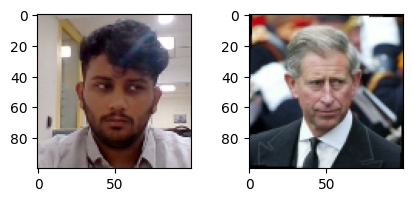

In [113]:
# Set plot size
plt.figure(figsize=(5,2))

# Divide the plot into 2 parts and give 1 column to each
plt.subplot(1,2,1)
# Show the input image
plt.imshow(test_input[3])

# Set the subplot for the 2nd column
plt.subplot(1,2,2)

# show the image
plt.imshow(test_val[3])

# THis is to finally show the whole figure
plt.show()

# 7. Save the Model

In [114]:
# Save weights
siamese_model.save('siamesemodel.keras')

In [1]:
# Reload Model

model = tf.keras.models.load_model('siamesemodel.keras',custom_objects = {'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

NameError: name 'tf' is not defined

In [116]:
model.predict([test_input,test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


array([[[1.0000000e+00],
        [9.9995810e-01],
        [2.0060884e-10],
        [2.7343175e-12],
        [5.8609192e-08],
        [1.0000000e+00],
        [1.0000000e+00],
        [9.6285382e-13],
        [9.9999875e-01],
        [1.0000000e+00],
        [1.0000000e+00],
        [3.6941818e-11],
        [2.3689365e-13],
        [1.0000000e+00],
        [5.7818583e-10],
        [1.4112049e-12]]], dtype=float32)

In [117]:
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_6 (L1Dist)  │ (1, None, 4096)   │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (1, None, 1)      │      4,097 │ l1_dist_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# 8. Real time test

## 8.1 Verification Function

In [118]:
def verify(model,detection_threshold,verification_threshold):
    # Detection_threshold: Mteric above which a prediction is considered positive
    # Verification_threshold: Proporation of positive prediction / total positive samples
    results=[]
    for image in os.listdir(os.path.join('application_data','verification_images')):
        input_img = preprocess(os.path.join('application_data','input_images','input_img.jpg'))
        verification_img = preprocess(os.path.join('application_data','verification_images',image))

        result = model.predict(list(np.expand_dims([input_img,verification_img],axis=1)))
        results.append(result)
    detection = np.sum(np.array(results)>detection_threshold)
    verification = detection / len(os.listdir(os.path.join('application_data','verification_images')))
    verified = verification > verification_threshold
    return results,verified
        
    

## 8.2 Open CV Real Time verification

In [122]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_images', 'input_img.jpg'), frame)
        # # Run verification
        results, verified = verify(model, 0.8, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
True
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
False


In [98]:
np.sum(np.squeeze(results)>0.8)

4

In [99]:
29/50

0.58